In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Flatten, Dense, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import activations
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Conv2D, Input, Flatten, Dense, BatchNormalization, LeakyReLU, \
    MaxPooling2D, Dropout, Concatenate, Activation
import random
import numpy as np
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from google.colab import drive
from sklearn.metrics import classification_report

In [2]:
SIZE = (128, 128)

drive.mount('/content/drive')

folder_aircrafts_path = '/content/drive/MyDrive/olehratinskiy_diploma_dataset/'

types = ['attack_helicopters', 'fighter_aircrafts', 'il-76', 'tu-22', 'tu-95', 'tu-160', 'noaircrafts']

img_list = []
labels = []

for idx, aircraft_type in enumerate(types):
    for filename in sorted(os.listdir(folder_aircrafts_path + aircraft_type + '/')):
        img_path = os.path.join(folder_aircrafts_path + aircraft_type + '/', filename)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, SIZE)
        img_list.append(img_resized)
        labels.append(idx)

X = np.array(img_list)
labels = np.array(labels)

Mounted at /content/drive


In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(X, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
print(len(X_train), len(X_test), len(X_val))
print(len(y_train), len(y_test), len(y_val))

696 88 87
696 88 87


In [5]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train_one_hot = to_categorical(y_train, len(types))
y_val_one_hot = to_categorical(y_val, len(types))
y_test_one_hot = to_categorical(y_test, len(types))

In [6]:
def conv_block(x, filters, kernel_size, padding):
    x = Conv2D(filters, kernel_size=kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def choose_drop_path_type(gl_dp_p, lc_dp_p):
    gl_dp = random.choices([True, False], [gl_dp_p, lc_dp_p])[0]
    lc_dp = not gl_dp
    return gl_dp, lc_dp

def get_gl_dp_index(columns_count):
    return random.randint(0, columns_count - 1)

def get_lc_dp_indexes(joining_paths_count, prob=0.5):
    drop_paths_idxs = []
    for i in range(joining_paths_count):
        if random.random() < prob:
            drop_paths_idxs.append(i)
    if len(drop_paths_idxs) == joining_paths_count:
        drop_paths_idxs.pop(random.randint(0, joining_paths_count - 1))
    return drop_paths_idxs

def join_paths(inputs):
#     sum_input = tensorflow.keras.backend.sum(inputs, axis=0)
    average = tf.reduce_mean(inputs, axis=0)
    print(average)
    return average

def fractal_block(inputs, columns_count, filters, kernel_size, padding, gl_dp_p, lc_dp_p):
    gl_dp, lc_dp = choose_drop_path_type(gl_dp_p, lc_dp_p)
    print(f"gl_dp={gl_dp}, lc_dp={lc_dp}")
    if gl_dp:
        selected_path = get_gl_dp_index(columns_count)

    column_path = [[inputs] for _ in range(columns_count)]

    for i in range(1, pow(2, columns_count - 1) + 1):
        count = 0
        for j in range(columns_count):
            if i % pow(2, j) == 0:
                column_path[j].append(conv_block(column_path[j][-1], filters, kernel_size, padding))
                count += 1

        if count > 1:
            last_columns_vals = [column_path[j][-1] for j in range(count)]
            if lc_dp:
                drop_paths_idxs = get_lc_dp_indexes(count)
                last_columns_vals = [last_columns_vals[j] for j in range(len(last_columns_vals))
                                     if j not in drop_paths_idxs]
            elif gl_dp and i == pow(2, columns_count - 1):
                last_columns_vals = [column_path[selected_path][-1]]

            joined_val = join_paths(last_columns_vals)
            for j in range(count):
                column_path[j].append(joined_val)

    last_val = column_path[-1][-1]
    return last_val

def fractal_network(input_shape, blocks_count, columns_count, filters, kernel_size, padding):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(blocks_count):
        x = fractal_block(x, columns_count, filters, kernel_size, padding, gl_dp_p=0.5, lc_dp_p=0.5)
        x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Flatten()(x)
    output_layer = Dense(len(types), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output_layer)
    return model

In [7]:
shape = (128, 128, 3)

In [8]:
plt.figure(figsize=(14, 6))

fractal_model = fractal_network(shape, blocks_count=4, columns_count=4, filters=32, kernel_size=(3, 3), padding='same')
fractal_model.compile(keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_fractalnet = fractal_model.fit(X_train, y_train_one_hot, epochs=200, batch_size=64, validation_data=(X_val, y_val_one_hot))

gl_dp=False, lc_dp=True
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean/Mean:0', description="created by layer 'tf.math.reduce_mean'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_1/Mean:0', description="created by layer 'tf.math.reduce_mean_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_2/Mean:0', description="created by layer 'tf.math.reduce_mean_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_3/Mean:0', description="created by layer 'tf.math.reduce_mean_3'")
gl_dp=True, lc_dp=False
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_4/Mean:0', description="created by layer 'tf.math.reduce_mean_4'")
KerasTensor(type_spec=TensorSpec(shape

<Figure size 1400x600 with 0 Axes>

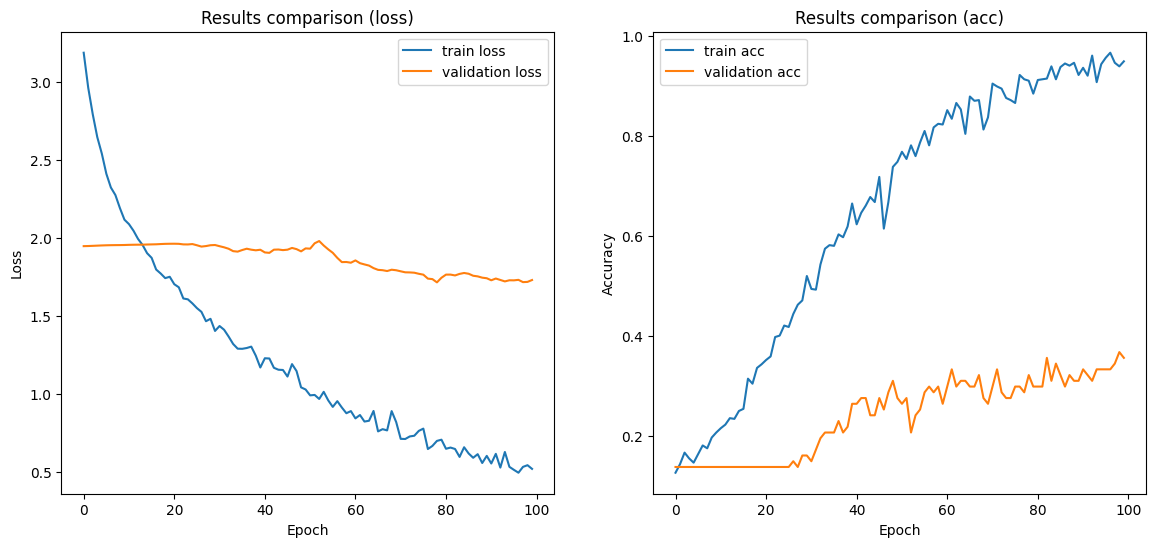

In [9]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_fractalnet.history['loss'][:100], label='train loss')
plt.plot(history_fractalnet.history['val_loss'][:100], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Results comparison (loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fractalnet.history['accuracy'][:100], label='train acc')
plt.plot(history_fractalnet.history['val_accuracy'][:100], label='validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Results comparison (acc)')
plt.legend()
plt.show()

In [10]:
predictions = fractal_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_result = accuracy_score(y_test, predicted_labels)

print("Test samples accuracy:", accuracy_result)

3/3 [==============================] - 2s 300ms/step
Test samples accuracy: 0.3977272727272727


In [ ]:
y_test_encoded = tf.keras.utils.to_categorical(y_test)
test_loss = fractal_model.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", test_loss)

Test loss: [1.7006577253341675, 0.35227271914482117]


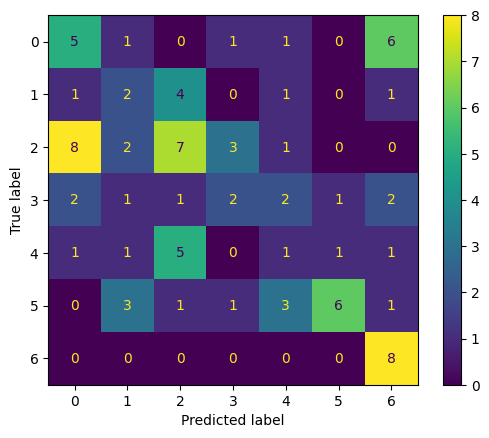

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_labels)
ConfusionMatrixDisplay(cm).plot()

In [14]:
classification_results = classification_report(y_test, predicted_labels, target_names=types)

print("Classification results:\n", classification_results)

Classification results:
                     precision    recall  f1-score   support

attack_helicopters       0.36      0.29      0.32        14
 fighter_aircrafts       0.33      0.44      0.38         9
             il-76       0.65      0.62      0.63        21
             tu-22       0.00      0.00      0.00        11
             tu-95       0.20      0.20      0.20        10
            tu-160       0.47      0.47      0.47        15
       noaircrafts       0.29      0.62      0.40         8

          accuracy                           0.40        88
         macro avg       0.33      0.38      0.34        88
      weighted avg       0.38      0.40      0.38        88



In [ ]:
X_train = X_train * 255.0
X_val = X_val * 255.0
X_test = X_test * 255.0

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='uint8'
)

updated_images = []
updated_labels = []

for img, label in zip(X_train, y_train):
    img = img.reshape((1,) + img.shape) / 255.0  # Normalize here
    label_one_hot = to_categorical(label, num_classes=len(types))  # Convert label to one-hot
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label_one_hot)

X_train = np.array(updated_images)
y_train = np.array(updated_labels)

# Repeat the same process for X_val and X_test

updated_images = []
updated_labels = []

for img, label in zip(X_val, y_val):
    img = img.reshape((1,) + img.shape) / 255.0  # Normalize here
    label_one_hot = to_categorical(label, num_classes=len(types))  # Convert label to one-hot
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label_one_hot)

X_val = np.array(updated_images)
y_val = np.array(updated_labels)

updated_images = []
updated_labels = []

for img, label in zip(X_test, y_test):
    img = img.reshape((1,) + img.shape) / 255.0  # Normalize here
    label_one_hot = to_categorical(label, num_classes=len(types))  # Convert label to one-hot
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label_one_hot)

X_test = np.array(updated_images)
y_test = np.array(updated_labels)

In [ ]:
print(len(X_train), len(X_test), len(X_val))
print(len(y_train), len(y_test), len(y_val))

20880 2640 2610
20880 2640 2610


In [ ]:
plt.figure(figsize=(14, 6))

fractal_model = fractal_network(shape, blocks_count=4, columns_count=4, filters=32, kernel_size=(3, 3), padding='same')
fractal_model.compile(keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_fractalnet_augm = fractal_model.fit(X_train, y_train_one_hot, epochs=200, batch_size=64, validation_data=(X_val, y_val_one_hot))

gl_dp=True, lc_dp=False
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_16/Mean:0', description="created by layer 'tf.math.reduce_mean_16'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_17/Mean:0', description="created by layer 'tf.math.reduce_mean_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_18/Mean:0', description="created by layer 'tf.math.reduce_mean_18'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_19/Mean:0', description="created by layer 'tf.math.reduce_mean_19'")
gl_dp=False, lc_dp=True
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 32), dtype=tf.float32, name=None), name='tf.math.reduce_mean_20/Mean:0', description="created by layer 'tf.math.reduce_mean_20'")
KerasTensor(type_spec=Te

ValueError: Data cardinality is ambiguous:
  x sizes: 20880
  y sizes: 696
Make sure all arrays contain the same number of samples.

<Figure size 1400x600 with 0 Axes>

In [ ]:
fractal_model.save('./fractalnet.h5')

In [ ]:
resnet_model = ResNet50(include_top=True,
                  weights=None,
                  input_shape=shape,
                  pooling='avg',
                  classes=len(types),
                  classifier_activation='softmax')

resnet_model.compile(keras.optimizers.RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
history_resnet = resnet_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_val, y_val_one_hot))

Epoch 1/100
653/653 [==============================] - 75s 82ms/step - loss: 1.6487 - accuracy: 0.3878 - val_loss: 2.1753 - val_accuracy: 0.2391
Epoch 2/100
653/653 [==============================] - 49s 75ms/step - loss: 1.4477 - accuracy: 0.4641 - val_loss: 1.6408 - val_accuracy: 0.4678
Epoch 3/100
653/653 [==============================] - 49s 74ms/step - loss: 1.3326 - accuracy: 0.5075 - val_loss: 1.5202 - val_accuracy: 0.4782
Epoch 4/100
653/653 [==============================] - 48s 74ms/step - loss: 1.2197 - accuracy: 0.5496 - val_loss: 1.3189 - val_accuracy: 0.5628
Epoch 5/100
653/653 [==============================] - 48s 74ms/step - loss: 1.1173 - accuracy: 0.5883 - val_loss: 1.1874 - val_accuracy: 0.5877
Epoch 6/100
653/653 [==============================] - 48s 74ms/step - loss: 0.9888 - accuracy: 0.6354 - val_loss: 1.2999 - val_accuracy: 0.5682
Epoch 7/100
653/653 [==============================] - 48s 74ms/step - loss: 0.8690 - accuracy: 0.6818 - val_loss: 1.1694 - val_ac

In [ ]:
vgg_model = VGG16(include_top=True,
                  weights=None,
                  input_shape=shape,
                  pooling='avg',
                  classes=len(types),
                  classifier_activation='softmax')
vgg_model.compile(keras.optimizers.RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

NameError: name 'VGG16' is not defined

In [ ]:
history_vgg = vgg_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_val, y_val_one_hot))

NameError: name 'vgg_model' is not defined

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_fractalnet.history['val_loss'][:100], label='fractalnet')
plt.plot(history_resnet.history['val_loss'], label='resnet')
plt.plot(history_vgg.history['val_loss'], label='vgg16')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Results comparison (loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fractalnet.history['val_accuracy'][:100], label='fractalnet')
plt.plot(history_resnet.history['val_accuracy'], label='resnet')
plt.plot(history_vgg.history['val_accuracy'], label='vgg16')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Results comparison (acc)')
plt.legend()
plt.show()